In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers,models, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_dir = '/content/drive/MyDrive/data/train'
val_dir = '/content/drive/My Drive/data/val'

In [ ]:
total_train = 0
for i in os.listdir(train_dir):
    total_train += len(os.listdir(os.path.join(train_dir, i)))
    print('Total File in', i, '=', len(os.listdir(os.path.join(train_dir, i))))

print('Total training files:', total_train)

# Calculate the total number of files in the validation directory
total_val = 0
for i in os.listdir(val_dir):
    total_val += len(os.listdir(os.path.join(val_dir, i)))
    print('Total File in', i, '=', len(os.listdir(os.path.join(val_dir, i))))

print('Total validation files:', total_val)

# Calculate the total number of files in the dataset
total_files = total_train + total_val
print('Total dataset files:', total_files)

Total File in biological = 788
Total File in plastic = 800
Total File in metal = 800
Total File in paper = 800
Total File in glass = 800
Total File in cardboard = 800
Total training files: 4788
Total File in biological = 197
Total File in plastic = 200
Total File in metal = 200
Total File in paper = 200
Total File in glass = 200
Total File in cardboard = 200
Total validation files: 1197
Total dataset files: 5985


In [ ]:
import random
import matplotlib.image as mpimg
def view_random_image(target_dir, target_class):
    # Combine the target directory and class to form the full path
    target_folder = target_dir + target_class

    # Randomly select an image from the target folder
    random_image = random.sample(os.listdir(target_folder), 1)

    # Read and display the image
    img = mpimg.imread(target_folder + '/' + random_image[0])
    plt.imshow(img)
    plt.title(target_class)
    plt.axis('off')

    # Print the shape of the image
    print(f"Ukuran gambar: {img.shape}")

    return img

Ukuran gambar: (384, 512, 3)


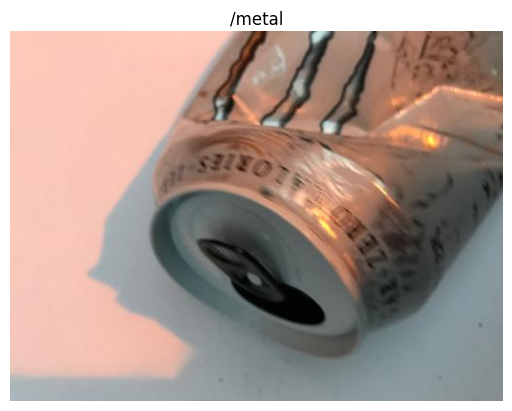

In [ ]:
img = view_random_image (train_dir, '/metal')

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

Found 4788 images belonging to 6 classes.
Found 1197 images belonging to 6 classes.


In [ ]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
base_model.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
model = models.Sequential()
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(1024, activation='relu', kernel_regularizer=l2(0.001)))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(6, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1024)              1311744   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 batch_normalization (Batch  (None, 512)               2

In [ ]:
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(learning_rate=0.0005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=2, verbose=1, factor=0.5, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[lr_reduction, early_stopping, model_checkpoint]
)

Epoch 1/20
150/150 [==============================] - ETA: 0s - loss: 1.8074 - accuracy: 0.7293 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


150/150 [==============================] - 2396s 16s/step - loss: 1.8074 - accuracy: 0.7293 - val_loss: 1.8552 - val_accuracy: 0.7335 - lr: 5.0000e-04
Epoch 2/20
150/150 [==============================] - 61s 404ms/step - loss: 1.4988 - accuracy: 0.7980 - val_loss: 1.4067 - val_accuracy: 0.8179 - lr: 5.0000e-04
Epoch 3/20
150/150 [==============================] - 58s 390ms/step - loss: 1.3275 - accuracy: 0.8254 - val_loss: 1.3990 - val_accuracy: 0.7995 - lr: 5.0000e-04
Epoch 4/20
150/150 [==============================] - 61s 404ms/step - loss: 1.2058 - accuracy: 0.8342 - val_loss: 1.2225 - val_accuracy: 0.8195 - lr: 5.0000e-04
Epoch 5/20
150/150 [==============================] - 59s 390ms/step - loss: 1.0814 - accuracy: 0.8484 - val_loss: 1.2275 - val_accuracy: 0.7970 - lr: 5.0000e-04
Epoch 6/20
150/150 [==============================] - 60s 398ms/step - loss: 0.9793 - accuracy: 0.8578 - val_loss: 1.0819 - val_accuracy: 0.8354 - lr: 5.0000e-04
Epoch 7/20
150/150 [===================

In [ ]:
val_loss, val_accuracy = model.evaluate(val_generator)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_accuracy}')

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

In [ ]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array

# Upload files
uploaded = files.upload()

for fn in uploaded.keys():
    path = fn
    img = load_img(path, target_size=(150, 150))

    # Convert the image to an array
    x = img_to_array(img)

    # Rescale the image
    x = x / 255.0

    # Expand the dimensions to match the input shape of the model
    x = np.expand_dims(x, axis=0)

    images = np.vstack([x])
    arr = model.predict(images, batch_size=10)

    # Get the index of the class with the highest probability
    predicted_class_index = np.argmax(arr)

    # Get the highest probability value
    predicted_probability = np.max(arr)

    # List of class labels
    class_labels = [
        'biological', 'cardboard', 'glass', 'metal', 'paper', 'plastic'
    ]

    # Determine the label
    predicted_label = class_labels[predicted_class_index]

    # Print the result with the probability of the predicted class
    print('{} is a {} with a probability of {:.2f}%'.format(fn, predicted_label, predicted_probability * 100))

    # Print the probabilities for all classes
    for i, prob in enumerate(arr[0]):
        print('Probability of {}: {:.2f}%'.format(class_labels[i], prob * 100))



Saving WhatsApp Image 2024-05-31 at 15.51.02.jpeg to WhatsApp Image 2024-05-31 at 15.51.02 (1).jpeg
1/1 [==============================] - 0s 48ms/step
WhatsApp Image 2024-05-31 at 15.51.02 (1).jpeg is a paper with a probability of 99.95%
Probability of biological: 0.00%
Probability of cardboard: 0.04%
Probability of glass: 0.01%
Probability of metal: 0.00%
Probability of paper: 99.95%
Probability of plastic: 0.00%


In [ ]:
model.save('wasteclassifierv2.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from google.colab import files

files.download('wasteclassifierv2.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>